In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import os, sys

# Load StarCraft2Sensor stuff
ipynb_dir = os.path.dirname(os.path.realpath("__file__"))
model_dir = os.path.join(ipynb_dir, 'models')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
code_root = os.path.join(ipynb_dir, '..')
sys.path.append(code_root)  # Needed for import below

from sc2sensor.dataset import StarCraftSensor
from sc2sensor.utils.unit_type_data import NONNEUTRAL_CHANNEL_TO_ID, NONNEUTRAL_ID_TO_NAME
CHANNEL_TO_NAME = [NONNEUTRAL_ID_TO_NAME[NONNEUTRAL_CHANNEL_TO_ID[i]] for i in range(len(NONNEUTRAL_CHANNEL_TO_ID))]

data_root = os.path.join(code_root, 'data') # Data root directory
data_subdir = 'starcraft-sensor-dataset'

In [2]:
DEVICE = 'cuda:1'
print(f'Using device: {DEVICE}')
torch.cuda.set_device(DEVICE)

Using device: cuda:1


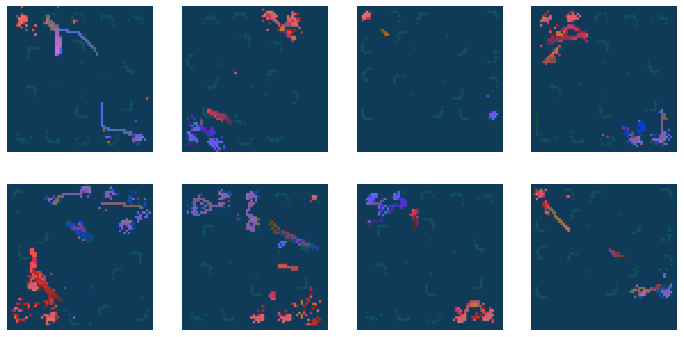

In [3]:
# Create datablock
from fastai.data.all import DataBlock, RandomSplitter
from fastai.vision.all import get_image_files, ImageBlock, MaskBlock

sc2_segment = DataBlock(
  blocks=(ImageBlock, MaskBlock(codes=CHANNEL_TO_NAME)),
  get_items=get_image_files,
  get_y=lambda filename: (os.path.splitext(filename)[0].replace('images','labels') + '_labels.png'),
  splitter=RandomSplitter(seed=0),
  batch_tfms=None)

segment_size = 'segment'
segment_path = Path(os.path.join(data_root, data_subdir, segment_size))
dls = sc2_segment.dataloaders(segment_path/'train'/'images', shuffle=True, bs=64)  # will be overwritten later
dls.show_batch(max_n=8)

In [ ]:
from fastai.vision.all import *
from fastai.callback.all import SaveModelCallback, EarlyStoppingCallback

shared_kwargs = dict(dls=dls, path=Path(code_root), model_dir='models')

experiments = [
#   ('unet_resnet18', resnet18, 1024),
#   ('unet_resnet34', resnet34, 1024),
#   ('unet_resnet50', resnet50, 512),
#   ('unet_xresnet18', xresnet18_deep, 512),
#   ('unet_xresnet34', xresnet34_deep, 1024),
#   ('unet_xresnet50', xresnet50_deep, 512),
#    ('unet_squeezenet1_0', squeezenet1_0, 256),
  ('unet_squeezenet1_1', squeezenet1_1, 512),
#   ('unet_densenet121', densenet121, 1024),
  ('unet_densenet169', densenet169, 128),
#   ('unet_densenet201', densenet201, 128),
]

# doing this in a function to help with memory leaks
def train_model(name, arch, batch_size):
        print(f'Starting {name} with size {batch_size}.')
        sc2_segment = DataBlock(
                          blocks=(ImageBlock, MaskBlock(codes=CHANNEL_TO_NAME)),
                          get_items=get_image_files,
                          get_y=lambda filename: (os.path.splitext(filename)[0].replace('images','labels') + '_labels.png'),
                          splitter=RandomSplitter(seed=0),
                          batch_tfms=None)
        dls = sc2_segment.dataloaders(segment_path/'train'/'images', shuffle=True, bs=batch_size, num_workers=12)
        callbacks = [
            EarlyStoppingCallback(patience=1),
            SaveModelCallback(fname=name, with_opt=True),
            ]
        # Create learner but then it gets overwritten to free memory
        learner = unet_learner(arch=arch, **shared_kwargs)
        learner.fine_tune(20, cbs=callbacks)
        print(f'Finished {name}.' + ('\n'*5))
        torch.cuda.empty_cache()
        return None
        


for name, arch, batch_size in experiments:
    train_model(name, arch, batch_size)

Starting unet_squeezenet1_1 with size 512.


/home/min/a/skulinsk/miniconda3/envs/starcraft/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


epoch,train_loss,valid_loss,time


In [ ]:
# learner.validate() # Uses validation set

In [ ]:
# # HACK: Put all instances in both "train" and "valid"
# # From https://forums.fast.ai/t/solved-not-splitting-datablock/84759/3
# def all_splitter(o): return L(int(i) for i in range(len(o))), L(int(i) for i in range(len(o)))

# sc2_segment_test = DataBlock(
#   blocks=(ImageBlock, MaskBlock(codes=CHANNEL_TO_NAME)),
#   get_items=get_image_files,
#   #get_y=lambda filename: segment_train_path / (os.path.splitext(filename)[0] + '_labels.png'),
#   get_y=lambda filename: (os.path.splitext(filename)[0].replace('images','labels') + '_labels.png'),
#   splitter=all_splitter,
#   batch_tfms=None)

# test_dls = sc2_segment_test.dataloaders(segment_path/'test'/'images', shuffle=False, bs=64)
# learner.validate(dl=test_dls.valid) # Uses validation set

In [ ]:
# learner.show_results(max_n=4, figsize=(7,8))

In [ ]:
# from fastai.vision.all import SegmentationInterpretation
# interp = SegmentationInterpretation.from_learner(learner)
# interp.plot_top_losses(k=3, largest=False)
# interp.plot_top_losses(k=3, largest=True)